### Swati Dogra - DSC 630  - Project 1 - Final Milestone

#### Amazon Stock Price Prediction Project 

##### Import the necessary libraries

Amazon stock price historical data is downloaded from NASDAQ website and includes daily closing prices over the past five years. 

In [488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from datetime import timedelta
import matplotlib.dates as mdates

# Load historical stock price data
data = pd.read_csv('C:/Users/swati/OneDrive/Desktop/Swati/Bellevue/DSC 680/Project 1/HistoricalData_Amazon.csv')


In [490]:
# Display the first few rows of the dataset
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,11/29/2024,$207.89,24892450,$205.83,$208.20,$204.59
1,11/27/2024,$205.74,28061640,$206.98,$207.64,$205.05
2,11/26/2024,$207.86,41673740,$201.90,$208.00,$201.79
3,11/25/2024,$201.45,40685670,$199.28,$201.9499,$199.00
4,11/22/2024,$197.12,31530840,$198.25,$199.2599,$196.75


#### Data processing steps

##### Rename the column "Close/Last" to "Close"

In [494]:
# Rename the column
data.rename(columns={'Close/Last': 'Close'}, inplace=True)

# Display the first few rows to ensure the changes are applied
print(data.head())


         Date    Close    Volume     Open       High      Low
0  11/29/2024  $207.89  24892450  $205.83    $208.20  $204.59
1  11/27/2024  $205.74  28061640  $206.98    $207.64  $205.05
2  11/26/2024  $207.86  41673740  $201.90    $208.00  $201.79
3  11/25/2024  $201.45  40685670  $199.28  $201.9499  $199.00
4  11/22/2024  $197.12  31530840  $198.25  $199.2599  $196.75


##### Remove the dollar signs and commas from the price data and convert it to numeric

In [497]:
# Remove special characters from the 'Close' column
data['Close'] = data['Close'].str.replace('$', '').str.replace(',', '')

# Convert the 'Close' column to float
data['Close'] = data['Close'].astype(float)

# Display the first few rows to ensure the changes are applied
print(data.head())


         Date   Close    Volume     Open       High      Low
0  11/29/2024  207.89  24892450  $205.83    $208.20  $204.59
1  11/27/2024  205.74  28061640  $206.98    $207.64  $205.05
2  11/26/2024  207.86  41673740  $201.90    $208.00  $201.79
3  11/25/2024  201.45  40685670  $199.28  $201.9499  $199.00
4  11/22/2024  197.12  31530840  $198.25  $199.2599  $196.75


##### Convert the 'Date' column to datetime and set it as the index

In [500]:
# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Ensure the data is sorted by date
data = data.sort_index()

# Display the first few rows to confirm the changes
print(data.head())


              Close    Volume      Open      High       Low
Date                                                       
2019-12-02  89.0800  78635000    $90.22  $90.2775   $88.134
2019-12-03  88.4980  70591640    $88.00  $88.6435  $87.3615
2019-12-04  88.0345  53614000  $88.7005  $89.4545   $88.011
2019-12-05  87.0240  56557040   $88.175   $88.175    $87.00
2019-12-06  87.5800  62399580    $87.56    $87.72  $87.0065


##### Display the number of missing values for each column 

In [503]:
missing_values = data.isnull().sum() 
print(missing_values)

Close     0
Volume    0
Open      0
High      0
Low       0
dtype: int64


##### Creating additional features such as moving averages

In [506]:

# 7-day moving average
data['MA_7'] = data['Close'].rolling(window=7).mean()

# 30-day moving average
data['MA_30'] = data['Close'].rolling(window=30).mean()

# Display the first 50 rows of the processed data
print(data.tail(50))


             Close     Volume      Open       High        Low        MA_7  \
Date                                                                        
2024-09-20  191.60  100378600   $190.23    $191.84    $187.41  187.594286   
2024-09-23  193.88   36993110   $191.64    $194.45    $190.57  188.577143   
2024-09-24  193.96   43478930   $194.27    $195.37    $190.13  189.644286   
2024-09-25  192.53   26391140   $193.75  $193.9498    $192.16  190.735714   
2024-09-26  191.16   36334850   $194.31    $194.53    $189.54  191.347143   
2024-09-27  187.97   36002320   $190.68    $190.90    $187.34  191.567143   
2024-09-30  186.33   41680400   $187.14    $188.49    $184.65  191.061429   
2024-10-01  185.13   36044910   $184.90    $186.19  $183.4519  190.137143   
2024-10-02  184.76   23704060   $184.44    $186.60    $184.04  188.834286   
2024-10-03  181.96   30204300  $183.045    $183.44   $180.875  187.120000   
2024-10-04  186.51   41079010   $185.75    $187.60    $183.60  186.260000   

#### PreProcess the data

##### Preprocess the data by scaling and splitting it into training and testing sets

In [510]:
import warnings
warnings.filterwarnings('ignore')

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Splitting the Data
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Function to create sequences
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Verifying shapes 
print(X_train.shape, y_train.shape) 
print(X_test.shape, y_test.shape)

(906, 100, 1) (906,)
(152, 100, 1) (152,)


##### Use the trained model to make predictions on the test data

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


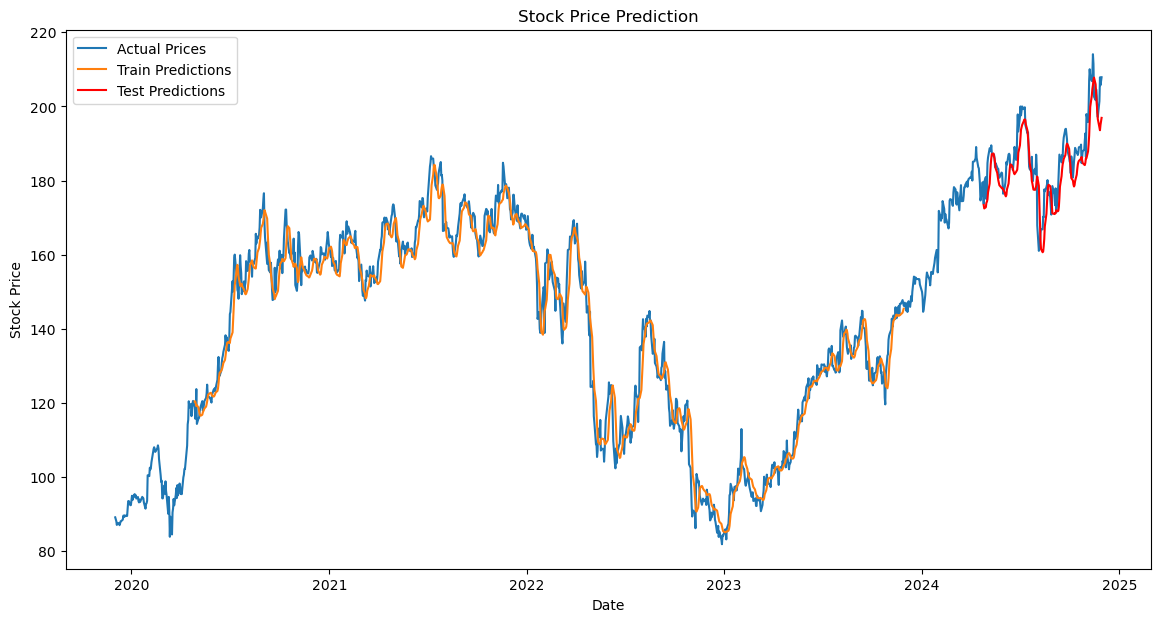

In [513]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Inverse transform the actual data
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data.index, scaler.inverse_transform(scaled_data), label='Actual Prices')
plt.plot(data.index[time_step:time_step+len(train_predictions)], train_predictions, label='Train Predictions')

# Adjust the x-axis range for test predictions
plt.plot(data.index[time_step+len(train_predictions)+time_step:], test_predictions, label='Test Predictions', color='red')
#plt.plot(data.index[2*time_step+len(train_predictions):-1], test_predictions, label='Test Predictions')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()

#####
Using the trained model, the Graph shows that the Train predictions and Test predictions are almost in line with the Actual stock price of Amazon.

##### Predict the Amazon stock price for Next Three Months in future

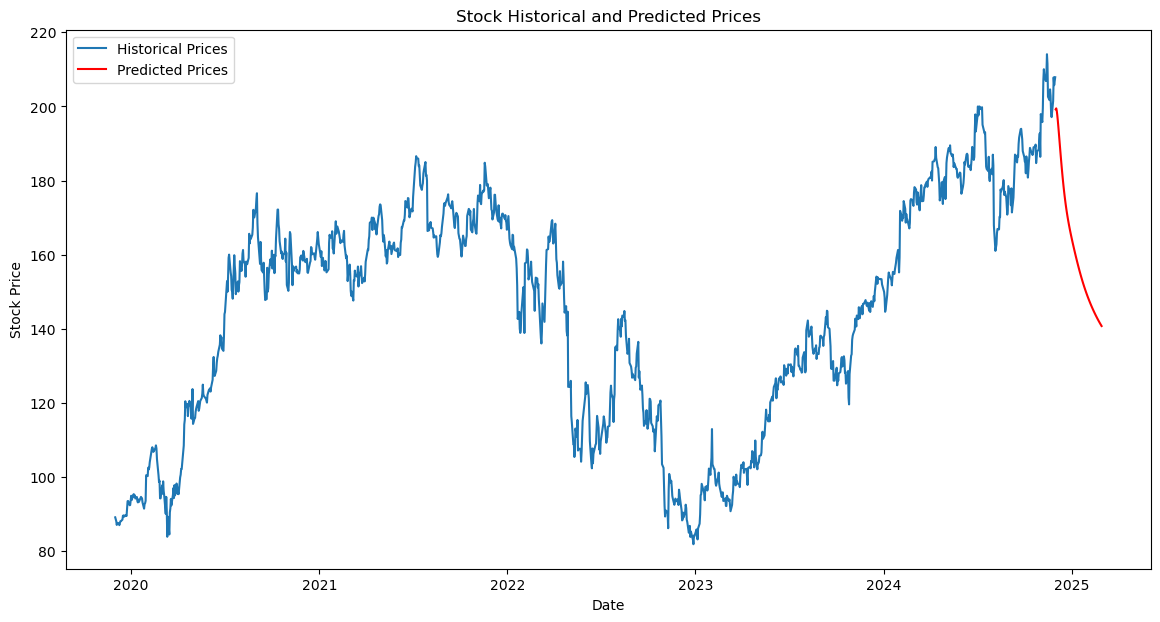

In [517]:
# Function to generate future dates
def generate_future_dates(start_date, days):
    return [start_date + timedelta(days=i) for i in range(1, days + 1)]

# Generate future dates for the next 3 months (~90 days)
future_days = 90
last_date = data.index[-1]
future_dates = generate_future_dates(last_date, future_days)

# Prepare the input data for the next 3 months prediction
future_predictions = []

# Take the last 100 days from the dataset as the starting point for prediction
last_100_days = scaled_data[-time_step:]

for i in range(future_days):
    X_input = last_100_days[-time_step:].reshape(1, -1)
    X_input = X_input.reshape((1, time_step, 1))
    pred = model.predict(X_input, verbose=0)
    future_predictions.append(pred[0, 0])
    last_100_days = np.append(last_100_days, pred)[1:]

# Inverse transform the predictions
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)

# Prepare future data for plotting
future_data = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_predictions.flatten()})
future_data.set_index('Date', inplace=True)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Historical Prices')
plt.plot(future_data.index, future_data['Predicted_Close'], label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Historical and Predicted Prices')
plt.legend()
plt.show()


#####
Future prediction of Amazon stock price shows there is a scope to reduce based on the scaled data without consideration of other external factors.

#### Methods and Analysis

##### Linear Regression Model

In [522]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare the data
data.reset_index(inplace=True)  # Reset index to have 'Date' as a column
data['Date'] = pd.to_datetime(data['Date'])  # Ensure 'Date' is in datetime format

# Feature Engineering: Extracting useful date features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Selecting features (date features) and target
X = data[['Year', 'Month', 'Day']]   # Feature (dates)
y = data['Close']                    # Target (closing prices)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Linear Regression Test MAE: {mae}')
print(f'Linear Regression Test MSE: {mse}')


# Training dataset predictions
train_predictions = lr_model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
print(f'Linear Regression Training Training MAE: {train_mae}')
print(f'Linear Regression Training Training MSE: {train_mse}')



Linear Regression Test MAE: 26.962902692936346
Linear Regression Test MSE: 897.8868025834802
Linear Regression Training Training MAE: 26.790233489785336
Linear Regression Training Training MSE: 880.010642005362


#####
Training vs. Test Metrics: The Mean Absolute Error (MAE) and Mean Squared Error (MSE) are very close between the training and test sets.

Training MAE vs. Test MAE: The values are very similar (26.79 vs. 26.96), indicating that the model performs consistently on both the training and test data.

Training MSE vs. Test MSE: The values are also quite similar (880.01 vs. 897.89), further suggesting consistent performance.

Based on these metrics, the model shows a good fit, with no significant signs of overfitting or underfitting. This implies that the Linear Regression model is appropriately capturing the relationships in the data without being overly complex or too simplistic. However, due to large MAE for a single stock price it is not really a good model.

##### ARIMA Model

In [526]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model (using historical data for evaluation)
arima_model = ARIMA(data['Close'], order=(5, 1, 0))  # Adjust order as needed
arima_model_fit = arima_model.fit()

# Make predictions
predictions = arima_model_fit.forecast(steps=30)  # Forecast for the next 30 days

# Evaluate the model (using historical data for evaluation)
y_test = data['Close'][-30:]  # Last 90 days for testing
future_mae_arima = mean_absolute_error(y_test, predictions)
future_mse_arima = mean_squared_error(y_test, predictions)
print(f'ARIMA MAE: {future_mae_arima}')
print(f'ARIMA MSE: {future_mse_arima}')

# Training Dataset predictions
train_predictions_arima = arima_model_fit.predict(start=0, end=len(data)-1)
train_mae_arima = mean_absolute_error(data['Close'], train_predictions_arima)
train_mse_arima = mean_squared_error(data['Close'], train_predictions_arima)
print(f'ARIMA Training MAE: {train_mae_arima}')
print(f'ARIMA Training MSE: {train_mse_arima}')


ARIMA MAE: 9.709855949030333
ARIMA MSE: 154.05935702050246
ARIMA Training MAE: 2.3243345697190114
ARIMA Training MSE: 15.856000706828674


#####
Training MAE vs. Test MAE: The training MAE (2.32) is significantly lower than the test MAE (9.71). This indicates that the model performs much better on the training data than on the test data.

Training MSE vs. Test MSE: The training MSE (15.86) is also significantly lower than the test MSE (154.06), suggesting that the model has learned the training data well but does not generalize as effectively to new data.

Conclusion:
Overfitting: The considerable difference between the training and test errors suggests that the ARIMA model is overfitting the training data. The model has learned the patterns in the training data, including noise, but fails to generalize to unseen data, leading to higher errors on the test set.

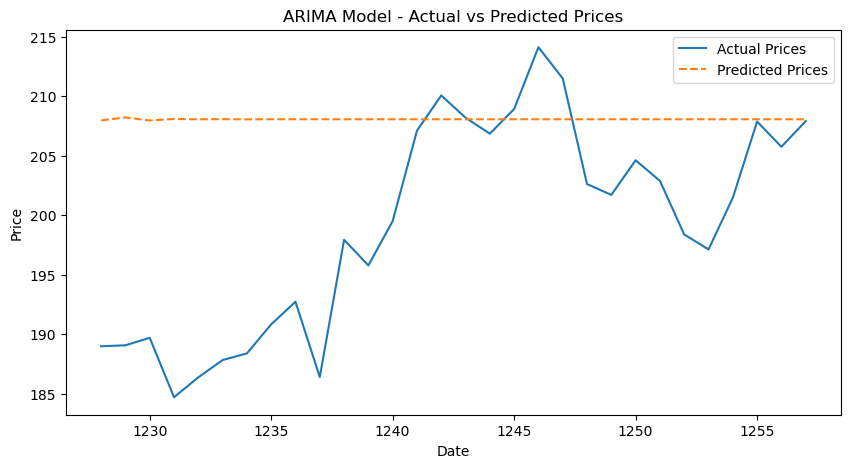

In [529]:
# Plot the predicted values - using ARIMA Model
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual Prices')
plt.plot(y_test.index, predictions, label='Predicted Prices', linestyle='dashed')
plt.title('ARIMA Model - Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


##### LSTM Model

In [532]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare the data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Prepare the training data
look_back = 60  # Number of previous days to consider
X, y = [], []
for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i-look_back:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Rescale to original values

# Evaluate the model
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
test_mae_lstm = mean_absolute_error(y_test_rescaled, predictions)
test_mse_lstm = mean_squared_error(y_test_rescaled, predictions)
print(f'LSTM Test MAE: {mae}')
print(f'LSTM Test MSE: {mse}')


# Training dataset performance
train_predictions_lstm = model.predict(X_train)
train_predictions_lstm = scaler.inverse_transform(train_predictions_lstm)
train_y_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))

train_mae_lstm = mean_absolute_error(train_y_rescaled, train_predictions_lstm)
train_mse_lstm = mean_squared_error(train_y_rescaled, train_predictions_lstm)
print(f'LSTM Training MAE: {train_mae_lstm}')
print(f'LSTM Training MSE: {train_mse_lstm}')


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0646
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0044
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0029
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0027
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0027
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0023
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0021
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0021
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0019
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0018
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0019
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0018
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0020
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0016
Epoc

#####
Training MAE vs. Test MAE: The training MAE (3.69) is significantly lower than the test MAE (26.96). This indicates that the model performs much better on the training data than on the test data.

Training MSE vs. Test MSE: The training MSE (23.41) is also significantly lower than the test MSE (897.89), suggesting that the model has learned the training data well but does not generalize as effectively to new data.

Overfitting: The considerable difference between the training and test errors suggests that the LSTM model is overfitting the training data. The model has learned the patterns in the training data, including noise, but fails to generalize to unseen data, leading to higher errors on the test set.

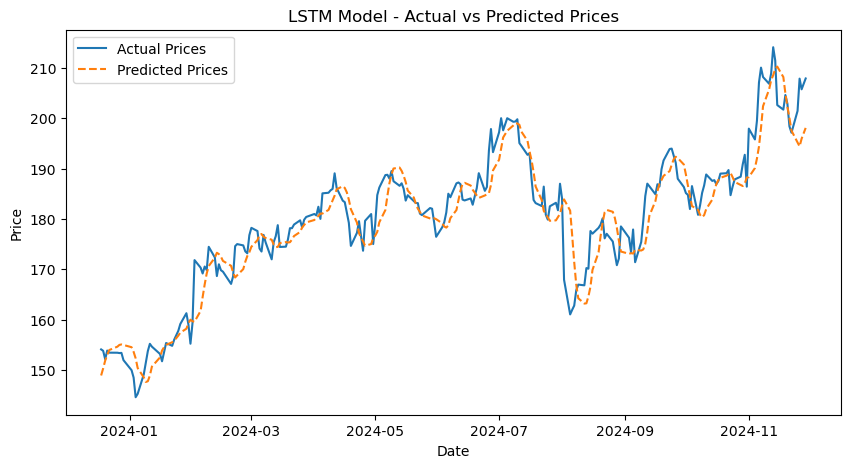

In [534]:
# Plot the predicted values - LSTM Model
plt.figure(figsize=(10, 5))
plt.plot(data.index[-len(y_test):], y_test_rescaled, label='Actual Prices')
plt.plot(data.index[-len(y_test):], predictions, label='Predicted Prices', linestyle='dashed')
plt.title('LSTM Model - Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


##### Using LSTM displaying the actual prices and predicted prices

In [536]:

# Actual values for the test set
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame for actual vs predicted values
lstm_results = pd.DataFrame({
    'Date': data.index[-len(y_test):],
    'Actual Prices': y_test_rescaled.flatten(),
    'Predicted Prices': predictions.flatten()
})
lstm_results.set_index('Date', inplace=True)

# Display the results
print(lstm_results)


            Actual Prices  Predicted Prices
Date                                       
2023-12-18         154.07        148.887833
2023-12-19         153.79        150.296951
2023-12-20         152.12        151.840576
2023-12-21         153.84        152.955963
2023-12-22         153.42        153.945862
...                   ...               ...
2024-11-22         197.12        197.539124
2024-11-25         201.45        195.205688
2024-11-26         207.86        194.393936
2024-11-27         205.74        195.932434
2024-11-29         207.89        198.072296

[240 rows x 2 columns]


#####
Above table shows the Actual prices and predicted prices of Amazon Stock price by date using the test dataset of LSTM model.

##### In addition, predicting the amazon stock price for next 30 days and its price.

In [539]:

# Prepare the test data for prediction 
test_data = scaled_data[-look_back:] # Last 60 days 
test_data = np.reshape(test_data, (1, look_back, 1))

# Predict the next 30 days
future_predictions = []
current_batch = test_data

for _ in range(30):
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

# Inverse transform the predictions
future_predictions = scaler.inverse_transform(future_predictions)

# Create a DataFrame to display the predictions
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')  # Business days
predictions_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['Predicted Prices'])

# Display the predictions
print(predictions_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

#####
Above data shows the predicted Amazon stock price for next 30 days using LSTM model and predicts a drop in Amazon stock price.